<strong style="font-size: 48px;">Job Turnover Analysis</strong>

In this notebook, I present my approach to the data analysis and predictive modelling of turnover at a company using a public dataset from Kaggle. The notebook is organized into the following sections:

Importing Libraries and Data:
Relevant packages and the provided dataset are imported in this section.

Exploratory Data Analysis (EDA):
An initial exploration of variable distributions is conducted, and the following questions are addressed:
* Which variables show a relationship with employee turnover?
* What type of relationship is observed?
* Is the relationship statistically significant?

Modeling:
A predictive model for employee turnover is proposed and evaluated using the provided dataset. This section addresses the following questions:
* Can we build a model to identify employees at high risk of turnover?
* What are the advantages and limitations of such a model?
* How can we evaluate the performance of a model of this nature?
* What other types of data could be valuable for enhancing these models?

Understanding Predictions
The following questions are revisited to better interpret the model's predictions:
* Which variables show a relationship with employee turnover?
* What type of relationship is observed?
* Is the relationship statistically significant?

Conclusions for Non-Technical Audiences and Future Steps
This section summarizes the answers to all previous questions and additionally addresses:
* Could we develop a model to identify high-risk candidates before hiring them?
* How would this model differ from the previous one?
* What recommendations would you give to the client to address this issue?

# Importing libraries and data

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, confusion_matrix

from scipy.stats import ttest_ind, chi2_contingency
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
import lightgbm as lgb
from sklearn.linear_model import LogisticRegression
import optuna
import shap

In [2]:
# Deterministic code
SEED = 42
random.seed = SEED
np.seed = SEED

In [3]:
train = pd.read_csv('turnover.csv', encoding='latin1')

# Exploratory Data Analysis (EDA)

## Data Cleaning

Checking NAs, duplicated records and the columns to understand their meaning:

In [4]:
print(train.isna().sum().sum())

0


In [5]:
print(train.duplicated().sum())

13


There are 11 duplicated records in train, I delete the duplicates.

In [6]:
train = train.drop_duplicates()

I also transform object to category

In [7]:
# From object to category
for df in [train]:  
    for col in df.select_dtypes(include=['object']).columns:  
        df[col] = df[col].astype('category')

Finally, we obtain the columns and their meaning from Kaggle.

In [8]:
print(sorted(train.columns))

['age', 'anxiety', 'coach', 'event', 'extraversion', 'gender', 'greywage', 'head_gender', 'independ', 'industry', 'novator', 'profession', 'selfcontrol', 'stag', 'traffic', 'way']


Based on the Kaggle dataset, the columns are defined as follows:

* **age**: Employee's age.  
* **anxiety**: Anxiety score.  
* **coach**: Indicates whether the employee had a coach during the probation period.  
* **event**: Indicates whether the employee left the company (turnover).  
* **extraversion**: Extraversion score.  
* **gender**: Employee's gender.  
* **greywage**: Indicates whether the salary is subject to taxation.  
* **head_gender**: Gender of the employee's supervisor.  
* **independ**: Independence score.  
* **industry**: Industry in which the employee works.  
* **novator**: Innovation score of the employee.  
* **profession**: Employee's profession.  
* **selfcontrol**: Self-control score of the employee.  
* **stag**: Employee's work experience.  
* **traffic**: Channel through which the employee entered the company.  
* **way**: Employee's transportation to work.  

## Variables Distribution

Let's get the distribution of the numerical variables.

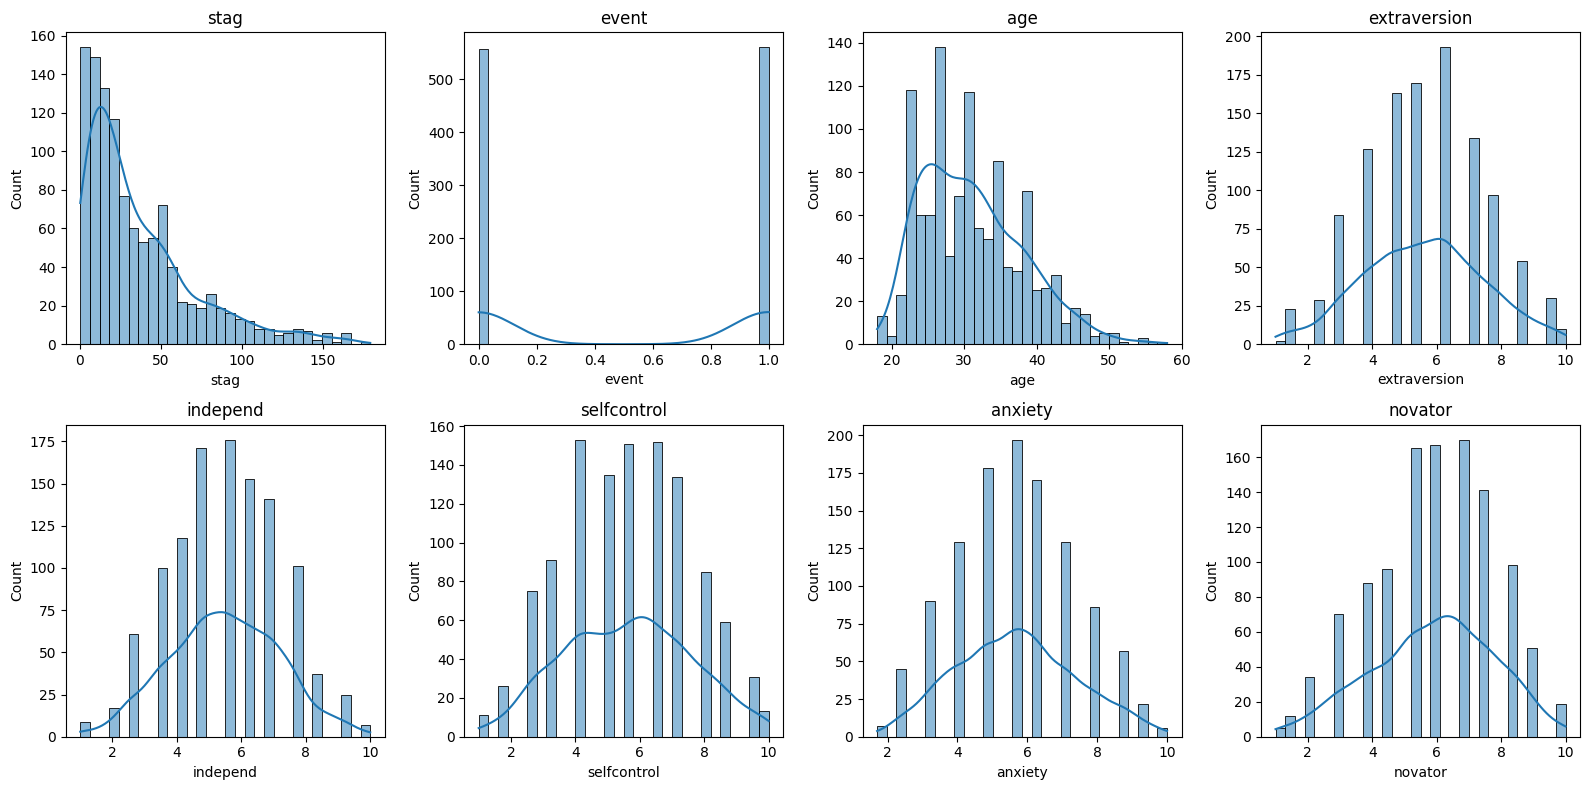

In [9]:
# Selecting numerical columns
num_cols = train.select_dtypes(include=['number']).columns

# Defining figure si<e
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(num_cols[:8]):  
    sns.histplot(train[col], bins=30, kde=True, ax=axes[i])
    axes[i].set_title(col)

plt.tight_layout()
plt.show()

Duration is similar to a logaritmic distribution or a truncated normal distribution. The other variables seem to follow a normal distribution.

Let's check the categorical variables distribution.

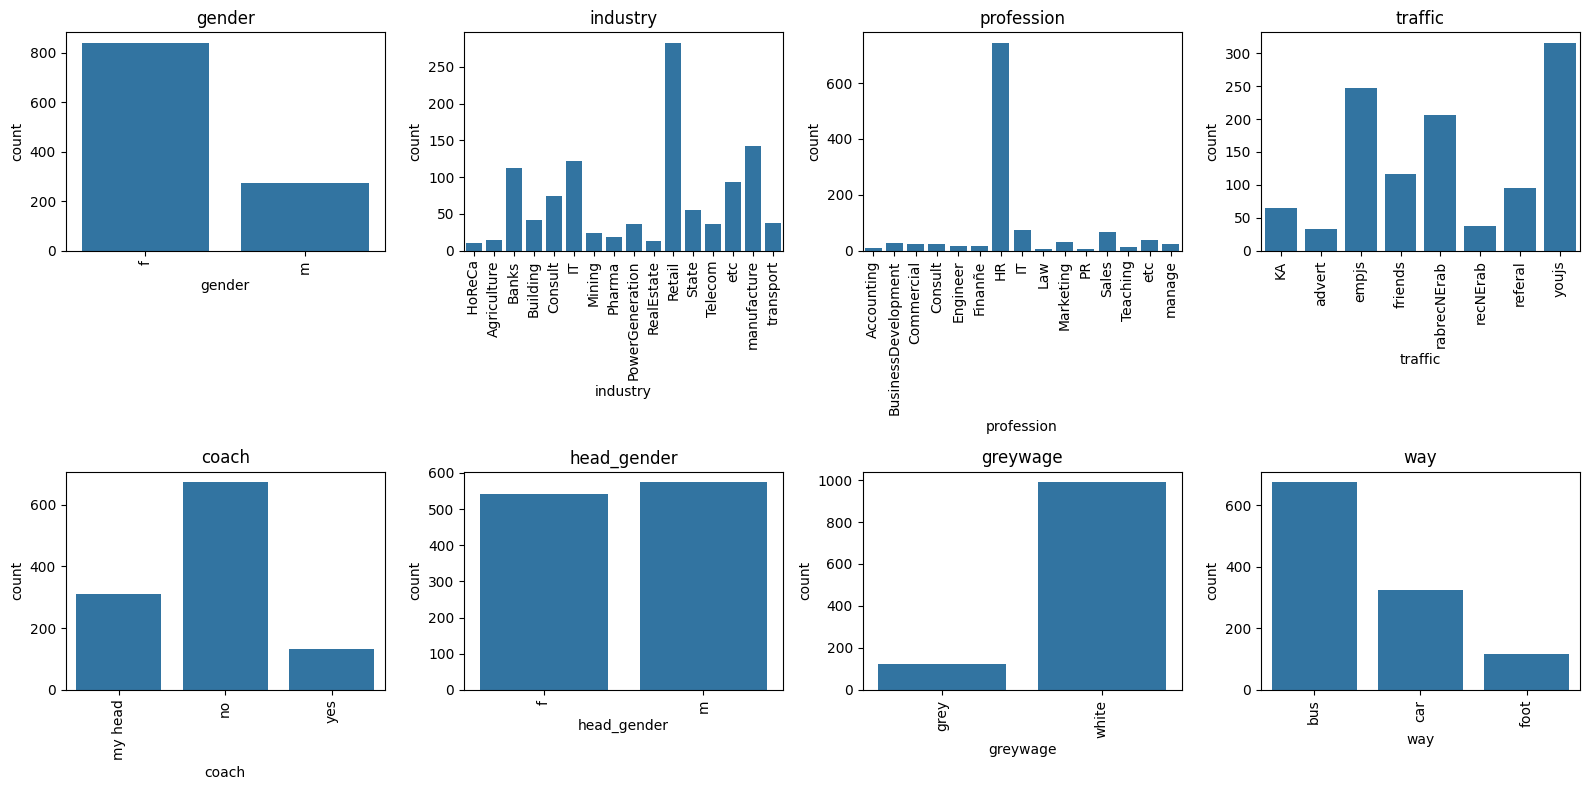

In [10]:
# Selecting categorical columns
cat_cols = train.select_dtypes(include=['object', 'category']).columns

# Defining figure size
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(16, 8))
axes = axes.flatten()

# Plot histograms
for i, col in enumerate(cat_cols[:8]):  
    sns.countplot(data=train, x=col, ax=axes[i])
    axes[i].set_title(col)
    axes[i].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

In columns such as *industry*, *profession*, and *greywage*, an imbalance across categories is observed, with a higher number of records corresponding to individuals in Retail, HR, and "white", respectively.

## Variables per class

In this subsection, I examine whether any variables, when considered individually or unidimensionally, can be used to predict turnover, and whether they are significant both statistically and in terms of effect size.

First I obtain the correlation matrix:

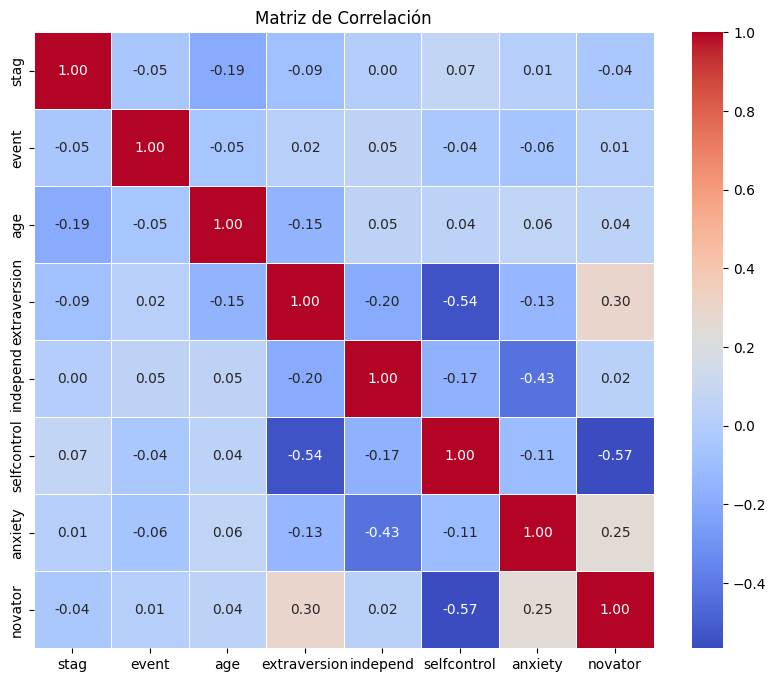

In [11]:
corr_matrix = train[num_cols].corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlación")
plt.show()

The correlations between the features and the target variable are very weak. Even the correlations among the predictor variables themselves are low. I will now assess whether the differences in group means are statistically significant.

In [12]:
# SPlit data on event
group_0 = train[train["event"] == 0]
group_1 = train[train["event"] == 1]

# Exclude categorical columns
num_cols = num_cols.drop("event")

# Find means and apply t-test
results = []
for col in num_cols:
    mean_0 = group_0[col].mean()
    mean_1 = group_1[col].mean()
    t_stat, p_value = ttest_ind(group_0[col], group_1[col], nan_policy="omit") 

    results.append({"Variable": col, "Mean_0": mean_0, "Mean_1": mean_1, "p-value": p_value})

# Transform to dataframe
ttest_df = pd.DataFrame(results)

# Plot results
print(ttest_df)

       Variable     Mean_0     Mean_1   p-value
0          stag  38.340981  35.074333  0.110373
1           age  31.398922  30.653218  0.074047
2  extraversion   5.556835   5.622143  0.557235
3      independ   5.395863   5.552500  0.124329
4   selfcontrol   5.685791   5.529821  0.189659
5       anxiety   5.772842   5.561250  0.038814
6       novator   5.859173   5.895357  0.751011


A common mistake would be to claim that individuals who leave the company tend to have less experience, be younger, more extroverted and independent, exhibit lower self-control, lower anxiety, and higher innovation. However, only one variable—*anxiety*—shows a statistically significant difference between groups, and even then, the effect size is quite small. Therefore, at this stage, I would not consider these variables to have strong predictive power on their own. Next, I will examine the behavior of the categorical variables.

In [13]:
# List for results
chi2_results = []

for col in cat_cols:
    contingency_table = pd.crosstab(train[col], train["event"])  
    chi2_stat, p_value, dof, expected = chi2_contingency(contingency_table)  
    
    chi2_results.append({"Variable": col, "p-value": p_value})

# Transform to dataframe
chi2_df = pd.DataFrame(chi2_results)

# Plot results
print(chi2_df)

      Variable       p-value
0       gender  6.274890e-01
1     industry  1.812230e-08
2   profession  2.832254e-05
3      traffic  5.522288e-06
4        coach  1.325789e-01
5  head_gender  1.888206e-01
6     greywage  1.399054e-01
7          way  8.367976e-03


Industry, profession, traffic and way show statistically significant differences at least between on pair of categories.

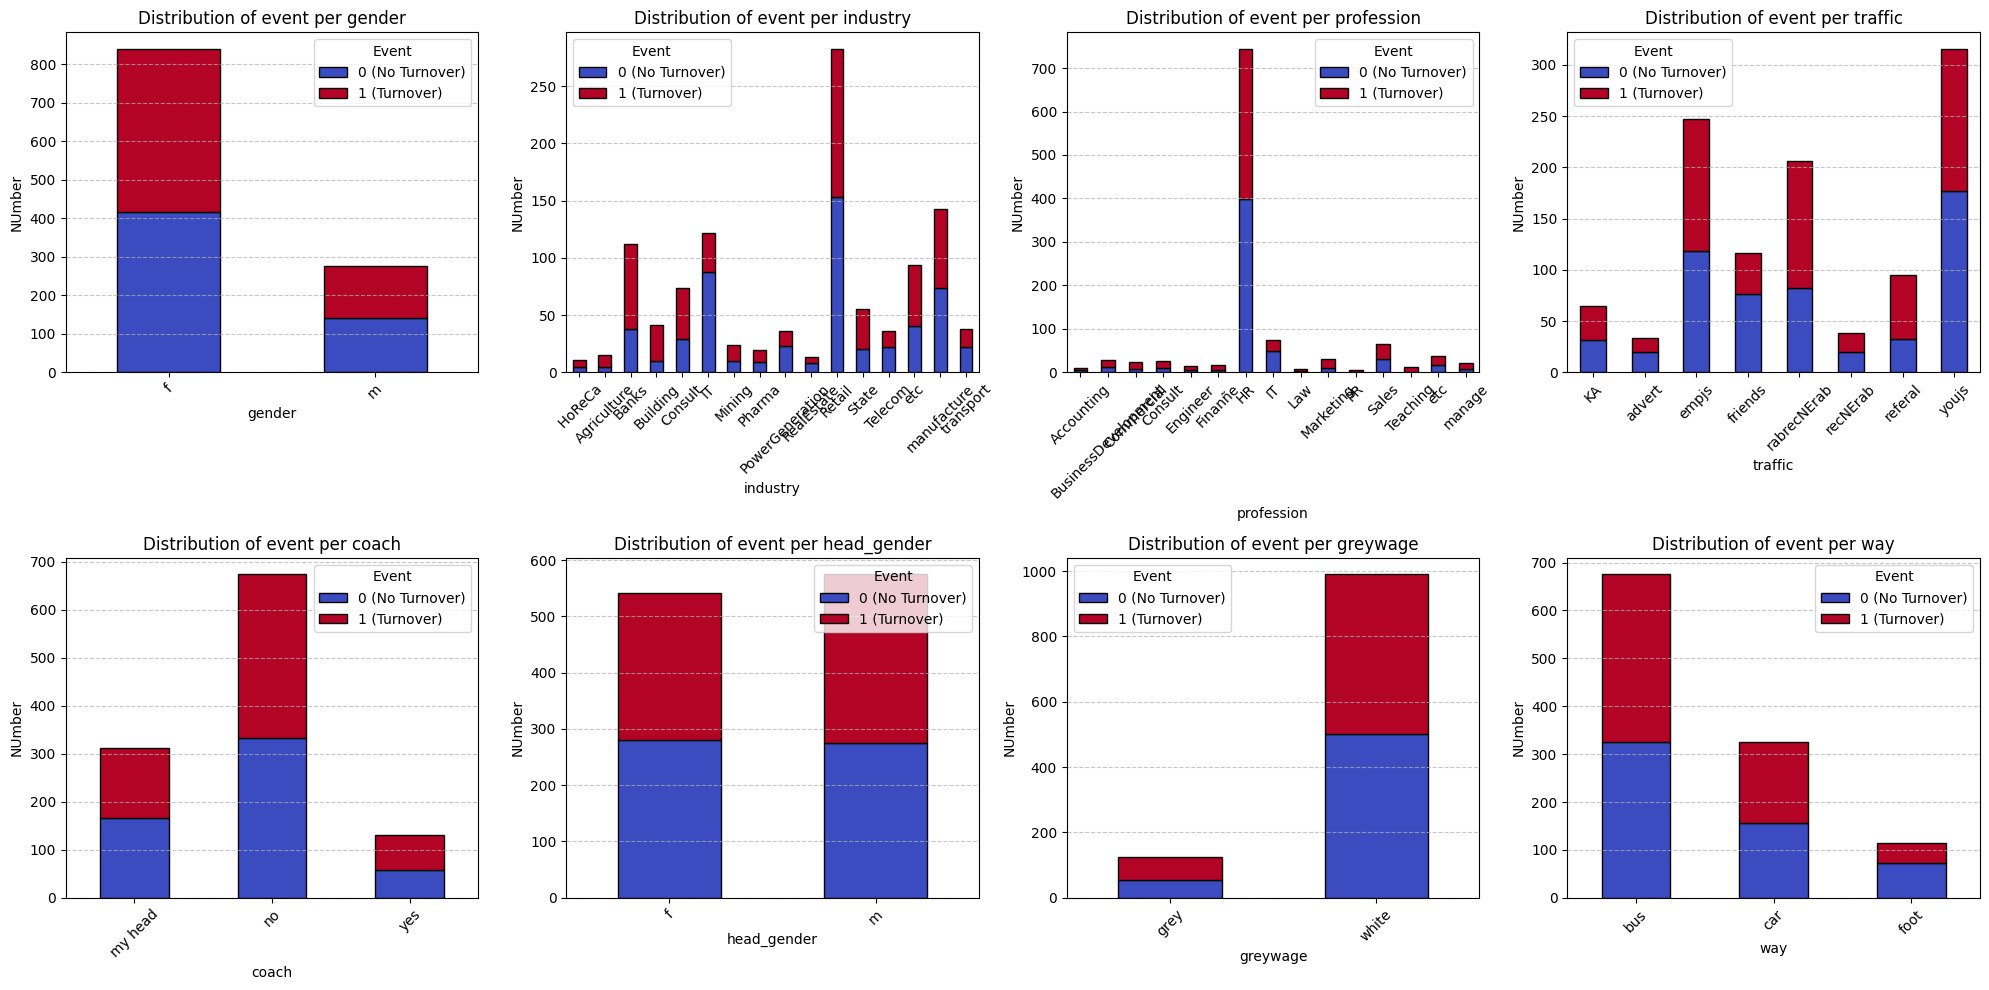

In [14]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(20, 10))  
axes = axes.flatten() 

for i, col in enumerate(cat_cols):
    contingency_table = pd.crosstab(train[col], train["event"])
    
    contingency_table.plot(kind="bar", stacked=True, ax=axes[i], colormap="coolwarm", edgecolor="black")
    
    axes[i].set_title(f"Distribution of event per {col}")
    axes[i].set_xlabel(col)
    axes[i].set_ylabel("NUmber")
    axes[i].legend(title="Event", labels=["0 (No Turnover)", "1 (Turnover)"])
    axes[i].tick_params(axis="x", rotation=45)
    axes[i].grid(axis="y", linestyle="--", alpha=0.7)

plt.tight_layout()
plt.show()

In this case, *industry*, *profession*, and *traffic* exhibit statistically significant differences between groups. For instance, within the *industry* variable, IT is associated with a lower risk of turnover, while banking is associated with a higher risk. However, some categories within *industry*, *profession*, and *traffic* have relatively small sample sizes, making it risky to assert that these categories have strong predictive power.

Insights:
* Numerical columns, when considered individually, are not strong predictors of the *event* variable. Only *anxiety* is statistically significant, but the difference in magnitude between groups is small.
* Among categorical variables, *industry*, *profession*, and *traffic* may serve as useful predictors.

Next Steps:
* Apply non-linear predictive models for turnover. This approach may reveal valuable information from variables that appear uninformative at first glance.

# Modeling

In this section, I demonstrate that it is possible to build a model that predicts turnover using the variables in the dataset. To achieve this, three models are trained to predict the target variable.

Pros of Building This Model:
* It can help reduce costs associated with recruiting new employees if actions are taken to retain those at high risk of turnover.
* It can also assist in forecasting departures and preparing the recruitment process for the upcoming vacancy.
* Additionally, it may help identify the most significant predictors of turnover and patterns of job dissatisfaction, which can be used to improve the organizational culture.

Cons of Building This Model:
* The quality of the model depends on the quality of the data.
* There may be underrepresented groups in the data, where the model's performance could significantly differ.
* Actions taken based on the model could lead to a "self-fulfilling prophecy." For example, employees who are offered a program or training to prevent turnover might feel pressured to resign.

Regarding the model performance evaluation, since the classes are balanced, accuracy will be used, which represents the percentage of correct predictions. In the case of imbalanced data, other metrics such as the F1 score can be employed, as they take into account both the percentage of employees of interest (turnover = 1) identified and the precision of the predictions.

There are also other indicators to evaluate performance, such as the change in accuracy with respect to the amount of training data or the training and prediction time. However, given the dataset's size, it does not make much sense to apply these methods.

Additionally, 10-fold cross-validation (CV) will be used for performance evaluation. In 10-fold CV, the data is split into 10 groups. To evaluate the model for each group, the model is trained on the remaining groups. By splitting the data into various groups that are not part of the training set, variance in the predictions is reduced, and the result becomes closer to what would be observed with external data (it is quite easy to make a single split in this data and overfit to achieve an accuracy above 73%).

## Logit CV

Logit is a linear model, where each change in a variable is associated with a change in the probability of turnover.

In [ ]:
# Create train copy and dummies
train_encoded = pd.get_dummies(train, drop_first=True)

# Split features and target
X = train_encoded.drop(columns=["event"])
y = train_encoded["event"]

# Defining optuna function
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-4, 10, log = True),  
        "penalty": trial.suggest_categorical("penalty", ["l1", "l2"]),  
        "solver": "liblinear",  
        "random_state": SEED, 
    }

    # 10-fold Cross-Validation
    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
    accuracies = []
    
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = LogisticRegression(**params)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_valid)
        accuracies.append(accuracy_score(y_valid, y_pred))
    
    return np.mean(accuracies)

# Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=25) 

# Save best hyperparameters
best_params_logit = study.best_params
print("Best hyperparams:", best_params_logit)

[I 2025-04-29 14:15:16,129] A new study created in memory with name: no-name-79ee2bc7-ee61-412f-b2a0-8b7f4008576c
[I 2025-04-29 14:15:16,526] Trial 0 finished with value: 0.48127413127413127 and parameters: {'C': 0.0074593432857265485, 'penalty': 'l1'}. Best is trial 0 with value: 0.48127413127413127.
[I 2025-04-29 14:15:16,644] Trial 1 finished with value: 0.5842985842985844 and parameters: {'C': 0.09846738873614563, 'penalty': 'l1'}. Best is trial 1 with value: 0.5842985842985844.
[I 2025-04-29 14:15:16,734] Trial 2 finished with value: 0.49827059202059204 and parameters: {'C': 0.00019517224641449495, 'penalty': 'l1'}. Best is trial 1 with value: 0.5842985842985844.
[I 2025-04-29 14:15:16,838] Trial 3 finished with value: 0.602228120978121 and parameters: {'C': 0.3470266988650412, 'penalty': 'l2'}. Best is trial 3 with value: 0.602228120978121.
[I 2025-04-29 14:15:17,237] Trial 4 finished with value: 0.6147763835263836 and parameters: {'C': 1.452824663751602, 'penalty': 'l1'}. Best i

Mejores hiperparámetros: {'C': 7.7621203197524595, 'penalty': 'l1'}


## LightGBM CV

LightGBM is a tree-based model that identifies non-linear dependencies within the data (e.g., women at the extremes of anxiety may have a higher risk of turnover than those at the average level).

In [ ]:
# Split features and target
X = train.drop(columns=["event"])
y = train["event"]

# Defining optuna function
def objective(trial):
    params = {
        "objective": "binary",
        "metric": "accuracy",
        "boosting_type": "gbdt",
        "learning_rate": trial.suggest_float("learning_rate", 0.01, 0.2, log=True),
        "num_iterations": trial.suggest_int("num_iterations", 100, 500),
        "num_leaves": trial.suggest_int("num_leaves", 20, 200),
        "max_depth": trial.suggest_int("max_depth", 3, 15),
        "min_data_in_leaf": trial.suggest_int("min_data_in_leaf", 10, 100),
        "lambda_l1": trial.suggest_float("lambda_l1", 1e-8, 10.0, log=True),
        "lambda_l2": trial.suggest_float("lambda_l2", 1e-8, 10.0, log=True),
        "feature_fraction": trial.suggest_float("feature_fraction", 0.5, 1.0),
        "bagging_fraction": trial.suggest_float("bagging_fraction", 0.5, 1.0),
        "bagging_freq": trial.suggest_int("bagging_freq", 1, 10),
        "verbose": -1,
        "seed": SEED, 
        "bagging_seed": SEED,  
        "feature_fraction_seed": SEED,
    }

    # 10-fold Cross-Validation 
    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
    accuracies = []
    
    for train_idx, valid_idx in kf.split(X):
        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        train_data = lgb.Dataset(X_train, label=y_train)
        valid_data = lgb.Dataset(X_valid, label=y_valid, reference=train_data)
        
        model = lgb.train(params, train_data, valid_sets=[valid_data])
        
        y_pred = (model.predict(X_valid) > 0.5).astype(int)
        accuracies.append(accuracy_score(y_valid, y_pred))
    
    return np.mean(accuracies)

# Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=25) 

# Save best hyperparameters
best_params_lgbm = study.best_params
print("Best hyperparameters:", best_params_lgbm)

[I 2025-04-29 14:15:24,717] A new study created in memory with name: no-name-fbdc1268-c415-4ef4-b73f-372d7eb77c94


c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\lightgbm\engine.py:204: UserWarning: Found `num_iterations` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instea

Mejores hiperparámetros: {'learning_rate': 0.02547754477298355, 'num_iterations': 444, 'num_leaves': 130, 'max_depth': 11, 'min_data_in_leaf': 11, 'lambda_l1': 2.005732281713052e-08, 'lambda_l2': 0.0014059172040583052, 'feature_fraction': 0.9980082658737177, 'bagging_fraction': 0.8576630868622772, 'bagging_freq': 8}


## SVM CV

Support Vector Machine classifies by creating "lines" to separate groups based on their characteristics.

In [ ]:
# Create train copy and dummies
train_encoded = pd.get_dummies(train, drop_first=True)

# Split features and target
X = train_encoded.drop(columns=["event"])
y = train_encoded["event"]

# Normalizing features
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

# Defining optuna function
def objective(trial):
    params = {
        "C": trial.suggest_float("C", 1e-4, 10, log=True),  # Regularización inversa
        "kernel": trial.suggest_categorical("kernel", ["linear", "rbf", "poly", "sigmoid"]),  # Tipos de kernel
        "gamma": trial.suggest_float("gamma", 1e-4, 1, log=True)  # Parámetro para kernels rbf, poly, sigmoid
    }

    # 10-fold Cross-Validation
    kf = KFold(n_splits=10, shuffle=True, random_state=SEED)
    accuracies = []
    
    for train_idx, valid_idx in kf.split(X_scaled):
        X_train, X_valid = X_scaled.iloc[train_idx], X_scaled.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
        
        model = SVC(**params, random_state=SEED)
        model.fit(X_train, y_train)
        
        y_pred = model.predict(X_valid)
        accuracies.append(accuracy_score(y_valid, y_pred))
    
    return np.mean(accuracies)

# Optuna study
study = optuna.create_study(direction="maximize", sampler=optuna.samplers.TPESampler(seed=SEED))
study.optimize(objective, n_trials=25) 

# Saving best hyperparameters
best_params_svm = study.best_params
print("Best hyperparameters:", best_params_svm)

[I 2025-04-29 14:16:58,684] A new study created in memory with name: no-name-85dfafdc-62aa-4f88-969b-8609d4e3dae2
[I 2025-04-29 14:16:59,141] Trial 0 finished with value: 0.6031209781209782 and parameters: {'C': 0.0074593432857265485, 'kernel': 'linear', 'gamma': 0.0004207053950287938}. Best is trial 0 with value: 0.6031209781209782.
[I 2025-04-29 14:16:59,533] Trial 1 finished with value: 0.47936776061776065 and parameters: {'C': 0.00019517224641449495, 'kernel': 'linear', 'gamma': 0.7579479953348001}. Best is trial 0 with value: 0.6031209781209782.
[I 2025-04-29 14:17:00,072] Trial 2 finished with value: 0.597804054054054 and parameters: {'C': 1.452824663751602, 'kernel': 'sigmoid', 'gamma': 0.012561043700013555}. Best is trial 0 with value: 0.6031209781209782.
[I 2025-04-29 14:17:00,676] Trial 3 finished with value: 0.48204633204633207 and parameters: {'C': 0.01444525102276306, 'kernel': 'rbf', 'gamma': 0.002920433847181412}. Best is trial 0 with value: 0.6031209781209782.
[I 2025-0

Mejores hiperparámetros: {'C': 1.264175241080592, 'kernel': 'poly', 'gamma': 0.07091635898717637}


The best model is LightGBM, with an accuracy of approximately 68%. While this is better than random prediction, the model could be improved by adding more data. Examples of potential data to include are:

* Distance to the workplace (if it is in-person).
* Number of working hours.
* Type of contract.
* Whether the employee has had a recent promotion.
* Whether the job requires travel outside the city.
* Overtime hours.
* Self-reported job satisfaction.

# Understanding predictions

c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')
c:\User

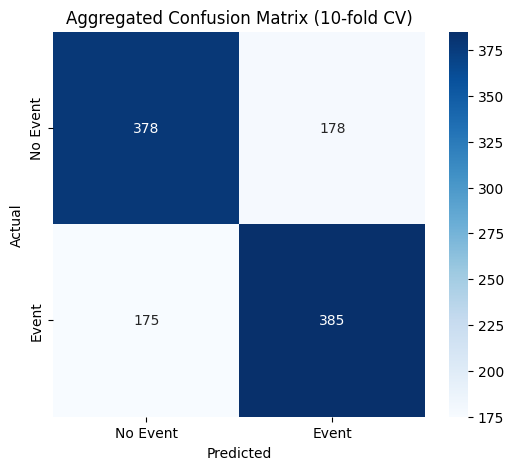

Mean Accuracy across folds: 0.6836
Standard Deviation of Accuracy: 0.0654


In [ ]:
# Split features and target
X = train.drop(columns=["event"])
y = train["event"]

# Obtaining best optuna hyperparams
best_params = study.best_params
best_params.update({
    "objective": "binary",
    "metric": "accuracy",
    "boosting_type": "gbdt",
    "verbose": -1,
    "seed": SEED
})

# 10-fold Cross-Validation
kf = KFold(n_splits=10, shuffle=True, random_state=SEED)

# Matrix and metrics
total_conf_matrix = np.array([[0, 0], [0, 0]])
accuracies = []
shap_importances = np.zeros(X.shape[1]) 

for train_idx, valid_idx in kf.split(X):
    X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
    y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]
    
    train_data = lgb.Dataset(X_train, label=y_train)
    valid_data = lgb.Dataset(X_valid, label=y_valid)
    
    model = lgb.train(best_params, train_data, valid_sets=[valid_data])
    
    # Predictions
    y_pred = (model.predict(X_valid) > 0.5).astype(int)
    
    # Obtaining confusion matrix
    fold_conf_matrix = confusion_matrix(y_valid, y_pred)
    total_conf_matrix += fold_conf_matrix

    # Saving accuracy
    accuracies.append(accuracy_score(y_valid, y_pred))

    # Calculating SHAP values and average feature importance
    explainer = shap.TreeExplainer(model)
    shap_values = explainer.shap_values(X_valid)

    if isinstance(shap_values, list): 
        shap_values = shap_values[1] 

    shap_importances += np.abs(shap_values).mean(axis=0) 

# Visualizing confusion matrix
plt.figure(figsize=(6, 5))
sns.heatmap(total_conf_matrix, annot=True, fmt=".0f", cmap="Blues", xticklabels=["No Event", "Event"], yticklabels=["No Event", "Event"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Aggregated Confusion Matrix (10-fold CV)")
plt.show()

# Mean and std of accuracy
mean_accuracy = np.mean(accuracies)
std_accuracy = np.std(accuracies)

print(f"Mean Accuracy across folds: {mean_accuracy:.4f}")
print(f"Standard Deviation of Accuracy: {std_accuracy:.4f}")

The standard deviation of the model's accuracy is less than 0.1. The errors are evenly distributed between False Positives and False Negatives.

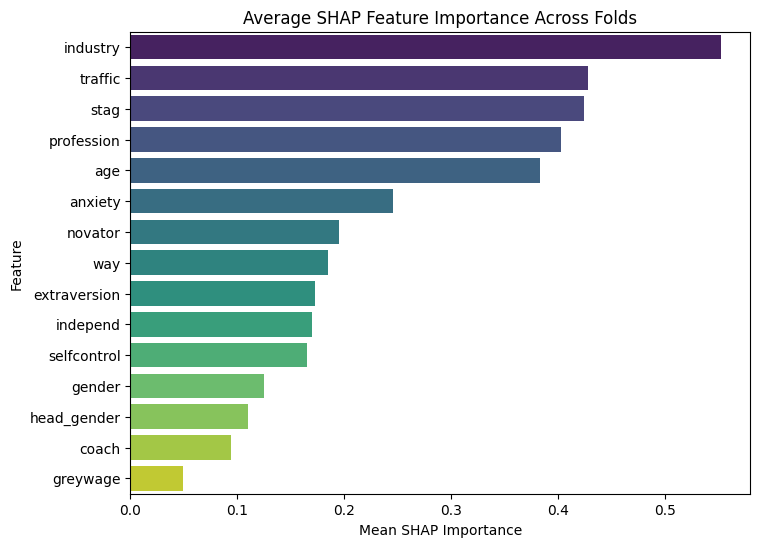

In [ ]:
# Average SHAP importances
shap_importances /= kf.get_n_splits()  # Mean across folds
shap_importance_df = pd.DataFrame({"Feature": X.columns, "SHAP Importance": shap_importances})
shap_importance_df = shap_importance_df.sort_values(by="SHAP Importance", ascending=False)

# Visualizing SHAP feature importances
plt.figure(figsize=(8, 6))
sns.barplot(
    data=shap_importance_df, 
    x="SHAP Importance", 
    y="Feature", 
    hue="Feature",  
    palette="viridis", 
    legend=False 
)
plt.xlabel("Mean SHAP Importance")
plt.ylabel("Feature")
plt.title("Average SHAP Feature Importance Across Folds")
plt.show()

Indeed, *industry*, *traffic*, *stag*, *profession*, and *age* are features that are prominently more important than the others, with nearly double the importance.

c:\Users\ifake\AppData\Local\Programs\Python\Python310\lib\site-packages\shap\explainers\_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


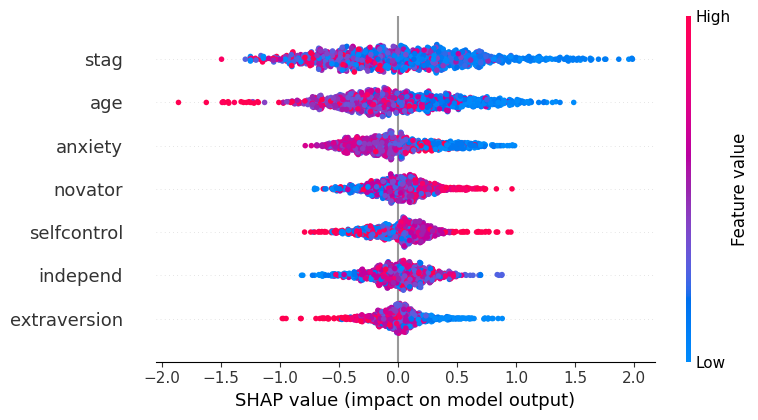

In [ ]:
shap_values_all = explainer.shap_values(X) 

# Selecting numerical columns
numeric_features = X.select_dtypes(include=["int64", "float64"]).columns

# Filtering SHAP values for numerical features
shap_values_numeric = shap_values_all[:, X.columns.isin(numeric_features)]
X_numeric = X[numeric_features]

# SHAP plot with numerical features only
shap.summary_plot(shap_values_numeric, X_numeric)

Interpreting the predictions:

* Higher *stag* -> lower turnover risk.
* Higher *age* -> higher turnover risk.
* Higher *anxiety* -> lower turnover risk.
* Higher *novator* -> higher turnover risk.
* Higher *selfcontrol* -> higher turnover risk.
* Higher *independ* -> has little impact on turnover.
* Higher *extraversion* -> lower turnover risk.

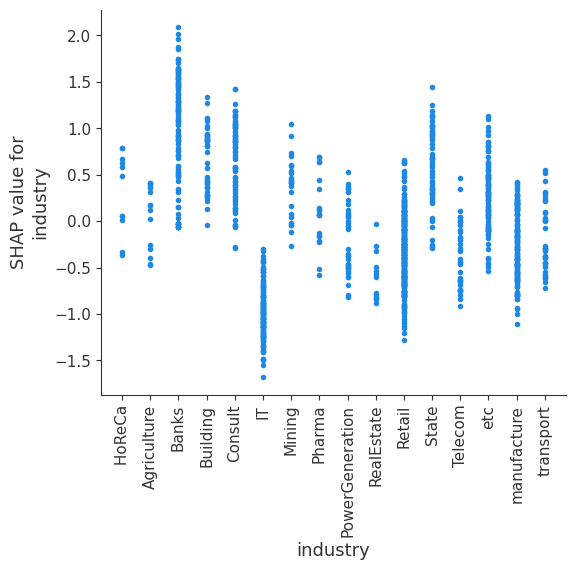

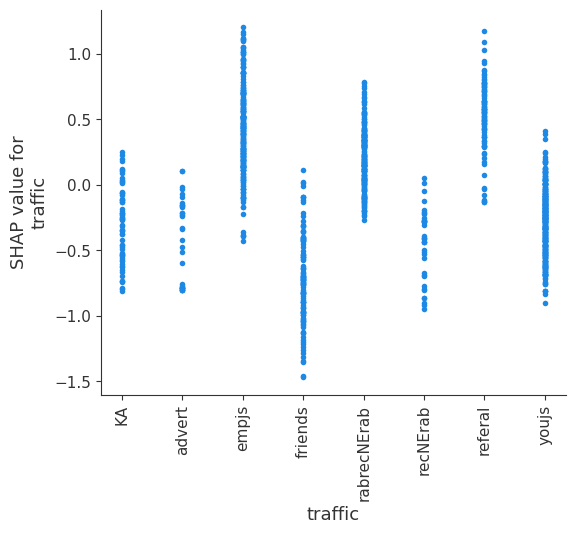

In [ ]:
for feature in ['industry', 'traffic']:
    shap.dependence_plot(feature, shap_values_all, X, interaction_index=None)

Interpreting the predictions for the most important categorical variables:

* In industry, IT is associated with a lower turnover risk compared to other categories, while banking is associated with a higher risk.
* Regarding how the employee entered the company, being hired through friends is associated with a lower turnover risk.

# Conclusions for Non-Technical Audiences and Future Steps

Regarding the results:

* It is possible to train a turnover prediction model, which can be evaluated based on its accuracy, averaging 68%.
* The advantages of this model include cost savings related to employee departures and the recruitment process for unexpected resignations.
* The drawbacks are that the model is only as good as its data, and it may be biased toward underrepresented groups. Additionally, there are risks when taking actions based on the model, as it could push employees to resign.
* To improve the model, additional data could be added, such as the employee's distance to the office, their self-reported job satisfaction, and administrative data like overtime, travel, and promotions.
* In terms of predictions, industry, the method through which the employee joined the company, and their tenure are the most important variables when predicting turnover.

Future steps:

* A model could be created to predict if an employee will have a high turnover risk prior to their hiring. In this case, some variables would be unavailable, and the focus would need to be on demographic variables or those obtained during the candidate evaluation. For example, their risk-taking disposition, years of education, number of previous jobs, average job tenure, etc. However, this approach carries the risk of introducing bias into the model.
* A model could also be developed to predict whether actions taken (e.g., onboarding, training, etc.) to prevent turnover will result in the retention of an employee.

Regarding the client's current situation, the main recommendations are:

* Develop retention programs for employees, particularly those in banking, consulting, and state sectors.
* Review the organizational culture: What causes higher turnover among banking employees? Is it related to stress?
* Specifically, the *stag* variable could suggest that employees perceive greater opportunities for career advancement or improvement by changing jobs rather than staying within the company. It would be worth studying promotions within the organization.
* Optimize the cost of applying retention programs through a model that also predicts which employees are more likely to be retained after receiving the programs.